# ReadMe
This file is intended to streamline the process of analyzing the data resulting from running the experiments in "falsifier.py" and "mult_obj_falsifier.py"

# Imports - TO DO CONDUCT AN ANALYSIS LOL

In [31]:
import pandas as pd
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import math
from natsort import os_sorted
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler


# Classify File Instances

In [4]:
def generate_velocity_csv(folder): #TODO - Either fix verifia for multi-obj or modify for that case
    """
        Builds csv containing velocity data for each simulation using the
        corresponding order of the params file returned by verifAI
    """

    ce_reg = r'.*\d_cex.*'
    nc_reg = r'.*no_cex.*'
    att_reg = r".*attacker_crash.*"


    non_ce_reg = [nc_reg,att_reg]
    

    start = os.getcwd()
    v1,v2,v3,v4 = [],[],[],[]

    files = os_sorted(os.listdir(folder))

    os.chdir(folder)
    ce_count = 0
    for file in files: #match counter-examples first
        found = re.match(ce_reg,  file)
        if found:
            file_data = pd.read_csv(file)
            v1.append(np.array(file_data["v1"]))
            v2.append(np.array(file_data["v2"]))
            v3.append(np.array(file_data["v3"]))
            v4.append(np.array(file_data["v4"]))
            ce_count+= 1

    
    for file in files: #match non counter examples second
        for reg in non_ce_reg:
            found = re.match(reg, file)
            if found:
                file_data = pd.read_csv(file)
                v1.append(np.array(file_data["v1"]))
                v2.append(np.array(file_data["v2"]))
                v3.append(np.array(file_data["v3"]))
                v4.append(np.array(file_data["v4"]))
                break

    os.chdir(start)

    return [v1,v2,v3,v4], ce_count


In [52]:

def read_folder(folder,sampler_file, attack_type):    
    """
    Data prepocessing: returns dataframe with test case specific features
    """

    velocity_data,ce_count = generate_velocity_csv(folder)


    simulation_params_df = pd.read_csv(sampler_file)

    if attack_type == "int":
        return(preprocess_intermittent(simulation_params_df,velocity_data)),ce_count
    if attack_type == "per":
        return(preprocess_persistent(simulation_params_df,velocity_data)),ce_count
    else:
        print("Error classifying attack type")


def preprocess_intermittent(sampler_data,velocities_df,):
    """
    Isolates relative columns and generates some new features for analysis

    Side Effect: Generates velocity graphs over time with attack indicators
    """
    intermittent_cols = ["Unnamed: 0","point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","rho"]
    sampler_data =sampler_data[intermittent_cols]
    col_names = {
        "Unnamed: 0" : "idx",
        "point.params.random_thr_br1": "random_thr_br1",
        "point.params.random_thr_br2" : "random_thr_br2",
        "point.params.random_t1" : "random_t1",
        "point.params.random_t2" : "random_t2",
        "point.params.random_t3" : "random_t3",
        "point.params.random_t4" : "random_t4",
        "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
        "rho" : "rho"
    }
    sampler_data = sampler_data.copy()
    sampler_data.rename(columns=col_names, inplace=True)
    output = get_attack_spacing_intermittent(sampler_data)
    output = velocity_at_attack_intermittent(sampler_data,velocities_df)
    

    return output

def preprocess_persistent(sampler_data,velocities_df):
    """
    Isolate relative columns and generates new featurs

    Side Effects: Generates velocity graphs over time with attack indicators
    """
    persistent_cols = [ "Unnamed: 0","point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
    sampler_data = sampler_data[persistent_cols]
    col_names = {
        "Unnamed: 0" : "idx",
        "point.params.amplitude_acc": "amplitude_acc",
        "point.params.attack_time" : "attack_time",
        "point.params.frequency" : "frequency",
        "point.params.inter_vehicle_distance" : "inter_vehicle_distance",
        "rho" : "rho"
    }
    sampler_data = sampler_data.copy()
    sampler_data.rename(columns=col_names, inplace=True)
    output = velocity_at_attack_persistent(velocities_df,sampler_data,True)
    return output




# Helper Functions

In [ ]:
def get_attack_spacing_intermittent(intermittent_df): # Calculate distance between each attack and add to Dataframe
    attack_spacing = []
    """
        Calcluates spacing between attacks and appends to given dataframe
    
    """

    for simulation_instance in range(len(intermittent_df)):
        diff_1 = intermittent_df["random_t2"][simulation_instance] - intermittent_df["random_t1"][simulation_instance] # t2 > t1
        diff_2 = intermittent_df["random_t3"][simulation_instance] - intermittent_df["random_t2"][simulation_instance]
        diff_3 = intermittent_df["random_t4"][simulation_instance] - intermittent_df["random_t3"][simulation_instance]

        sim_gaps = np.array([diff_1,diff_2,diff_3])
        attack_spacing.append(sim_gaps)

    attack_spacing = np.array(attack_spacing)
    col_names = ["t1_t2", "t2_t3", "t3_t4"]
    time_df = pd.DataFrame(attack_spacing, columns=col_names)

    return(pd.concat([intermittent_df, time_df],axis=1))


def velocity_at_attack_intermittent(intermittent_df,velocities_df): # Collect the attackers speed at each attack and append to Dataframe
    """
    Calculates velocity at attack times and appends to dataframe
    """
    times = intermittent_df[["random_t1", "random_t2", "random_t3","random_t4"]]

    attk_vel = []
    for sim in range(len(times)):
        sim_vel = []
        sim_length = len(velocities_df[0][sim])
        for col in times.columns:
            idx = math.ceil(times[col][sim]) * 10
            if idx < sim_length:
                sim_vel.append(velocities_df[0][sim][idx])
            else:
                sim_vel.append(0)
        attk_vel.append(sim_vel)
        
    col_names = ["t1_velocity", "t2_velocity", "t3_velocity", "t4_velocity"]
    attk_vel = np.array(attk_vel)
    final_df = pd.DataFrame(attk_vel, columns=col_names)

    if display:
        generate_intermittent_attack_graphs(velocities_df,times,intermittent_df)

    return get_attack_spacing_intermittent((pd.concat([intermittent_df,final_df],axis=1)))


def velocity_at_attack_persistent(velocities_df, persistent_df, display):
    """
    Calcluates velocity at attack time (initial), and average velocity for the remainder of the attack
    """
    attack_times= persistent_df["attack_time"]


    velocity_at_attack = []  # construct custom features
    avg_speed_after_attck = []

    for sim_instance in range(len(attack_times)):
        attack_time = math.ceil(attack_times[sim_instance] * 10) # account for timestep length
        velocity_at_attack.append(velocities_df[0][sim_instance][attack_time]) # velocity at attack time
        avg_speed_after_attck.append(np.average(velocities_df[0][sim_instance][attack_time:])) # collect that average speed after attack has occured

    velocity_at_attack = np.array(velocity_at_attack)
    avg_speed_after_attck = np.array(avg_speed_after_attck)
    col_names = [["pre_attack_velocity"],["attack_velocity_average"]]
    temp_df = pd.DataFrame(velocity_at_attack, columns=col_names[0])
    temp_df2 = pd.DataFrame(avg_speed_after_attck,columns=col_names[1]) 

    if display:
        generate_persistent_attack_graphs(velocities_df, persistent_df["frequency"],persistent_df["amplitude_acc"],persistent_df["attack_time"])
        


    return(pd.concat([persistent_df,temp_df,temp_df2],axis=1))                                    


In [ ]:
def distinguish_events(features_df, counter_ex_totals): # Todo improve or build upon to gather attacker_crash instanaces
    ce_df = features_df[:counter_ex_totals]
    non_ce_df = features_df[counter_ex_totals:]

    labels = np.concatenate((np.full(counter_ex_totals,1), np.full(len(features_df)- counter_ex_totals,0)))

    return ce_df, non_ce_df, labels

# Visualization Tools

In [78]:
def generate_persistent_attack_graphs(sim_velocities,att_freq,att_amplitude,times): # okay we gonna have to fix this up later
    """
    Graph Velocity over time w/ displayed amplitude and frequency   
    """
    for i in range(3):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two side-by-side plots

        x = range(len(sim_velocities[0][i]))

        # First subplot - Attacker vs Follower 1
        axes[0].plot(x, sim_velocities[0][i], label="Attacker")
        axes[0].plot(x, sim_velocities[1][i], linestyle="--", color="purple", label="Follower 1")

        axes[0].set_title(f"Velocity Over Time\nAttack Freq: {int(att_freq[i])}, Amp: {att_amplitude[i]:.2g}")
        axes[0].set_xlabel(f"Timesteps (.1 secs)")
        axes[0].set_ylabel("Velocity (m/s)")
        axes[0].legend()

        attack_time = math.ceil(times[i] * 10)
        axes[0].axvline(x=attack_time, color='red', alpha=0.7, label="Attack Time")

        # Second subplot - Followers 1, 2, and 3
        x_followers = range(len(sim_velocities[1][i]))
        axes[1].plot(x_followers, sim_velocities[1][i], linestyle="--", color="green", label="Follower 1")
        axes[1].plot(x_followers, sim_velocities[2][i], linestyle="--", color="blue", label="Follower 2")
        axes[1].plot(x_followers, sim_velocities[3][i], linestyle="--", color="purple", label="Follower 3")

        axes[1].set_title(f"Follower Velocities Over Time")
        axes[1].set_xlabel("Timesteps (.1 secs)")
        axes[1].set_ylabel("Velocity (m/s)")
        axes[1].legend()

        axes[1].axvline(x=attack_time, color='red', alpha=0.7, label="Attack Time")

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

def generate_intermittent_attack_graphs(velocities_list,times,intermittent_df):
    """
    Graph velocity over time w/ attack markers displaying attack start"
    
    """

    for i in range(0, 3):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots side by side

        # First subplot - Attacker velocity
        x = range(len(velocities_list[0][i]))
        axes[0].plot(x, velocities_list[0][i], label="Attacker")
        axes[0].plot(x, velocities_list[1][i], linestyle="--", color="purple", label="Follower 1")

        axes[0].set_title("Attacker Velocity (m/s) with attack markers")
        axes[0].set_xlabel("Timesteps (.1 secs)")
        axes[0].set_ylabel("Velocity (m/s)")
      
        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[0].axvline(x=attack_time, color='red', alpha=0.7, label=label )
            first = False


        axes[0].legend()

        # Second subplot - Followers velocity
        x = range(len(velocities_list[2][i]))
        axes[1].plot(x, velocities_list[1][i], linestyle="--", alpha=.7,  color="green", label="Follower 1")
        axes[1].plot(x, velocities_list[2][i], linestyle="--", alpha=.7, color="blue", label="Follower 2")
        axes[1].plot(x, velocities_list[3][i], linestyle="--", alpha=.7, color="purple", label="Follower 3")

        axes[1].set_title("Followers Velocity (m/s) over time with attack markers")
        axes[1].set_xlabel("Timesteps (.1 secs)")
        axes[1].set_ylabel("Velocity (m/s)")

        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[1].axvline(x=attack_time, color='red', alpha=0.7, label=label )
            first = False

        axes[1].legend()

        # Determine shared limits for x-axis and y-axis
        x_min = 0
        x_max = max(len(velocities_list[0][i]), len(velocities_list[2][i]))

        y_min = min(
            min(velocities_list[0][i]), min(velocities_list[1][i]),
            min(velocities_list[2][i]), min(velocities_list[3][i])
        )
        y_max = max(
            max(velocities_list[0][i]), max(velocities_list[1][i]),
            max(velocities_list[2][i]), max(velocities_list[3][i])
        )

        # Apply limits to both subplots
        axes[0].set_xlim(x_min, x_max)
        axes[1].set_xlim(x_min, x_max)
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)


        plt.tight_layout()  # Adjust layout to fit both plots properly
        plt.show()


# Cofactor Analysis

In [174]:
def cofactor_analysis(ce, non_ce):
    feature_names = ce.columns   
    X_ce = np.array(ce)
    X_non_ce = np.array(non_ce)
    
    X_ce_scaled = StandardScaler().fit_transform(X_ce)
    X_non_ce_scaled = StandardScaler().fit_transform(X_non_ce)
    
    corr_matrix_ce = np.corrcoef(X_ce_scaled.T)
    corr_matrix_non_ce = np.corrcoef(X_non_ce_scaled.T)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    im1 = ax1.imshow(corr_matrix_ce, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names)
    ax1.set_yticks(range(len(feature_names)))
    ax1.set_yticklabels(feature_names)
    ax1.set_title("Correlation Matrix for Counter-Examples")
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')  # Rotate x labels for readability
    
    im2 = ax2.imshow(corr_matrix_non_ce, cmap="RdBu_r", vmin=-1, vmax=1)
    ax2.set_xticks(range(len(feature_names)))
    ax2.set_xticklabels(feature_names)
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names)
    ax2.set_title("Correlation Matrix for No Counter-Examples")
    plt.setp(ax2.get_xticklabels(), rotation=90, ha='right')  # Rotate x labels for readability
    
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

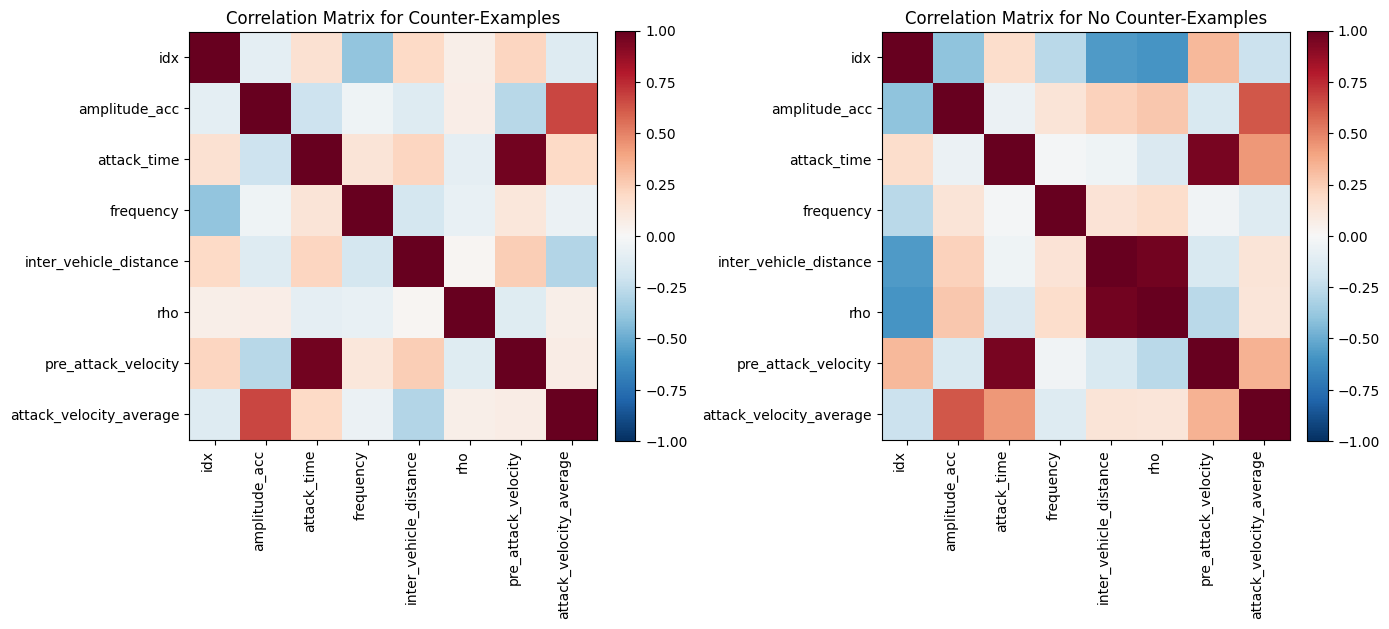

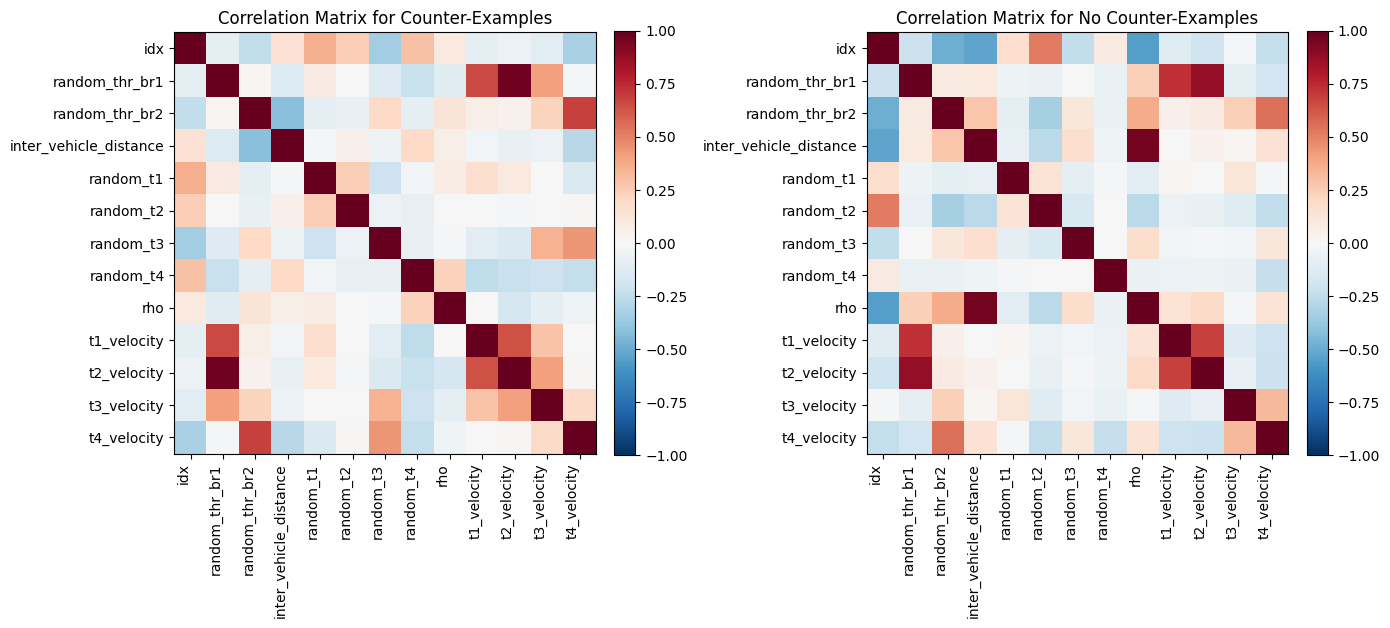

In [176]:
ce,non_ce, labels= distinguish_events(processed_data,ce_count1)
ce2, non_ce2, labels = distinguish_events(pd_2, ce_count2)

cofactor_analysis(ce,non_ce)
cofactor_analysis(ce2,non_ce2)

# Test

In [172]:
file_path = "../outputs/persistent_ce/persistent_attack_ce_ce.csv"
dir_path = "../outputs/persistent_ce"

file_path2 = "../outputs/intermittent_ce/intermittent_attack_ce_ce.csv"
dir_path2 = "../outputs/intermittent_ce"


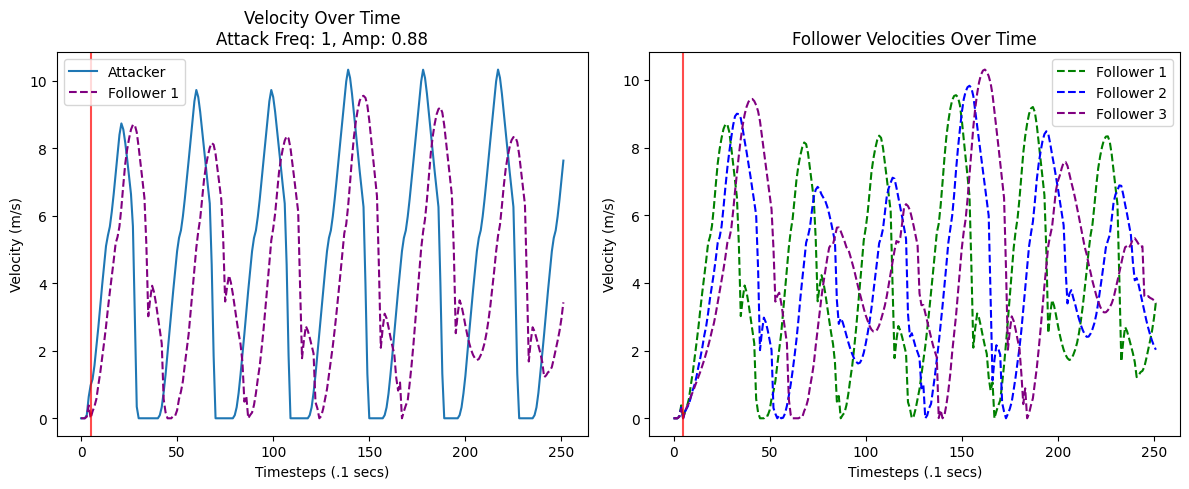

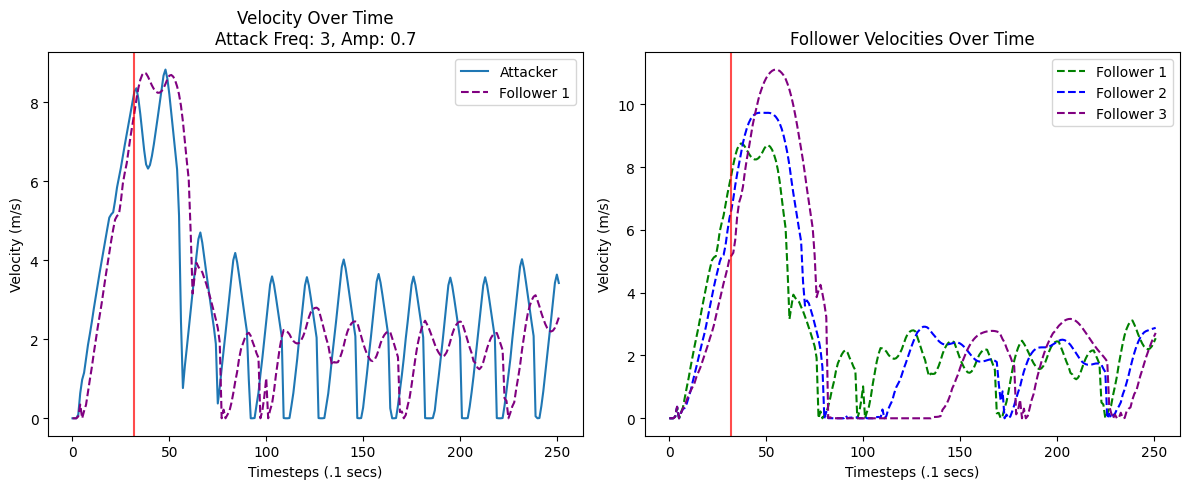

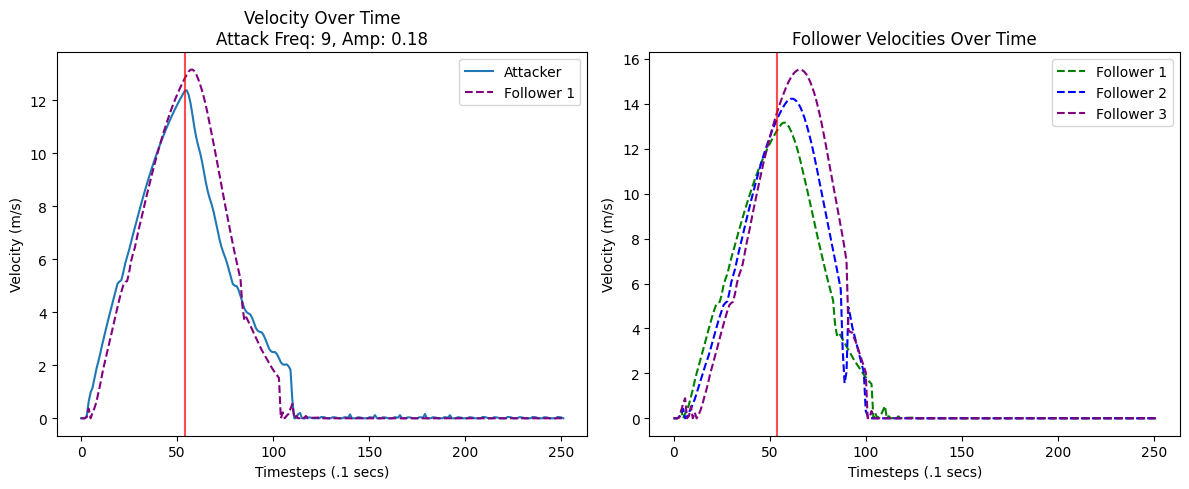

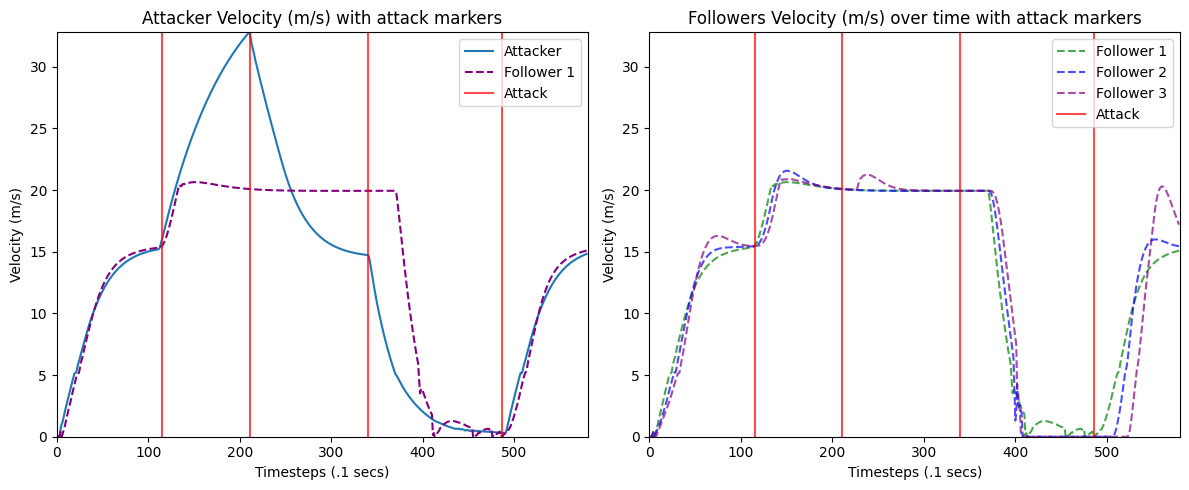

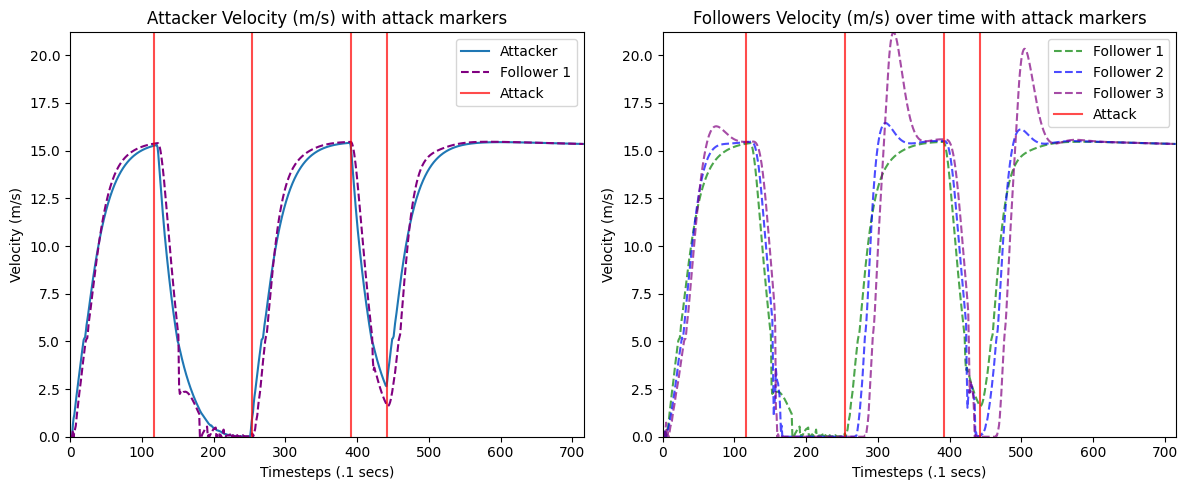

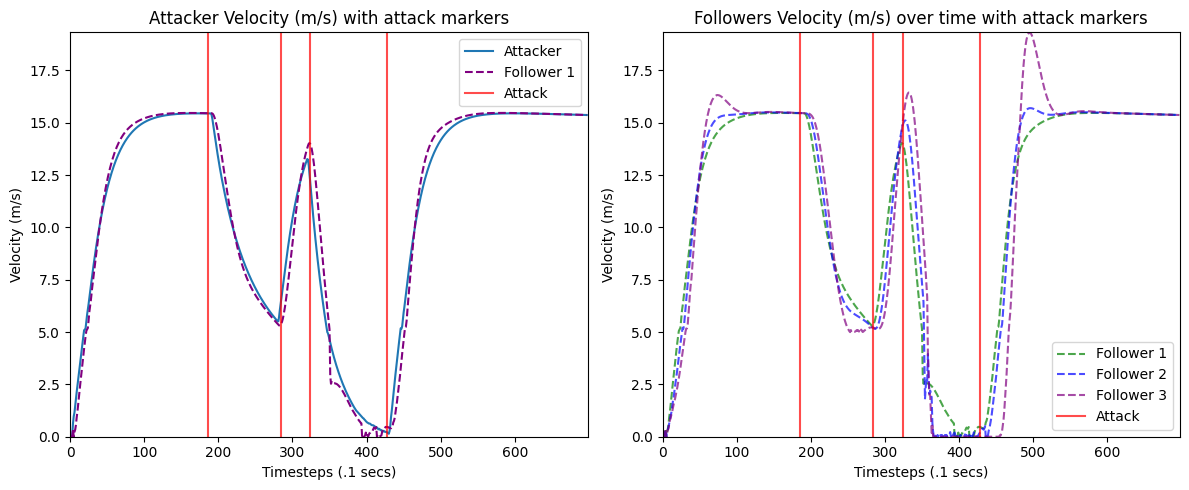

In [173]:
processed_data, ce_count1 = read_folder(dir_path, file_path,"per")
pd_2, ce_count2  = read_folder(dir_path2, file_path2, "int")

In [153]:
pd_2 = pd_2.drop(columns=["idx","rho"])
processed_data = processed_data.drop(columns=["idx","rho"])

In [156]:
X1 = StandardScaler().fit_transform(pd_2)
X2 = StandardScaler().fit_transform(processed_data)

# PCA Analysis

In [158]:
pca = PCA(n_components="mle")


In [160]:

X_pca = pca.fit(X1)

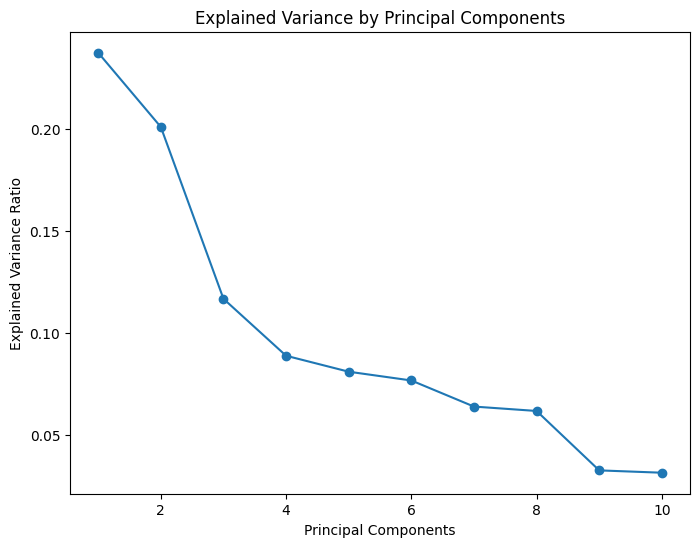

In [162]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(X_pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

In [163]:
feature_vals = pca.components_

In [166]:
feature_df = pd.DataFrame(feature_vals, columns=pd_2.columns)

In [171]:
for col in feature_df.columns:
    print(f"{col} : {list(feature_df[col])}")

random_thr_br1 : [0.5867524037981445, 0.0027944104872098447, -0.015485030065297596, 0.012496387500784715, -0.015414115465074938, -0.058143377113233544, -0.0240068567572966, -0.1092544342552274, -0.3035394578962513, 0.08186560746779882]
random_thr_br2 : [0.07844281730570835, 0.5335457976377236, -0.05544271539298241, 0.13130844942776734, -0.1413676628603352, 0.022021102821688614, 0.44791293280751115, -0.19851208363287848, 0.09475858238141949, -0.6470288325645603]
inter_vehicle_distance : [0.0702878708893807, 0.3354893990808627, 0.3014081149971929, 0.09475145331012721, 0.29987742642965165, 0.6434041134860623, -0.3378048503590412, -0.37629879682006334, 0.07236279009919622, 0.12520498821202597]
random_t1 : [-0.00572645490482218, -0.12697143732682872, -0.5215905173332659, 0.37979861350664745, 0.6194987876384682, 0.24968653299358531, 0.21656063624296554, 0.25347601976550205, -0.08079719350533461, -0.048611653220385936]
random_t2 : [-0.08485893393207553, -0.40222477733617856, -0.25740860881697